# Imports 

In [598]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import csv 
import seaborn as sns
import Dataset_processing as dp 
import torch.nn as nn
import matplotlib.pyplot as plt 
import torch.optim as optim
import seaborn as sns
import os
import cv2
from tqdm import tqdm 
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import transforms
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np 
from PIL import Image
import torch
import itertools
import copy
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.model_selection import ParameterGrid
import plot_dataset_distribution as data_plots 
from torchvision.transforms import ToTensor
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms



# Label encoding and Loading the Datasets

In [599]:
label_map = {
    "Glioma": 0,
    "Meningioma": 1,
    "Pituitary": 2,
    "No_Tumor": 3
}

# Reverse map to get readable labels
reversed_map = {
    0: "Glioma",
    1: "Meningioma",
    2: "Pituitary",
    3: "No_Tumor"
}

In [600]:
train_df = pd.read_csv('image_data/train.csv')
test_df = pd.read_csv('image_data/test.csv')
valid_df = pd.read_csv('image_data/valid.csv')

print("Train", train_df)
print("Test", test_df)
print("Valid", valid_df)



Train                                                filename       label
0                                           gl_2003.jpg      Glioma
1                                           pi_1224.jpg   Pituitary
2                                     me_image(107).jpg  Meningioma
3     gl_0126_jpg.rf.fae17fdfdba906952459f8c391267bf...      Glioma
4                                       gl_gg (133).jpg      Glioma
...                                                 ...         ...
6072                                         gl_787.jpg      Glioma
6073                                    gl_gg (632).jpg      Glioma
6074                                         me_234.jpg  Meningioma
6075                                     pi_p (295).jpg   Pituitary
6076                                     me_m2 (67).jpg  Meningioma

[6077 rows x 2 columns]
Test                                               filename       label
0                                      gl_gg (563).jpg      Glioma
1             

# Let us visualize our Data 

In [601]:
data_plots.data


[{'Split': 'train_images', 'Label': 'Glioma', 'Count': 2210},
 {'Split': 'train_images', 'Label': 'Meningioma', 'Count': 1505},
 {'Split': 'train_images', 'Label': 'Pituitary', 'Count': 1720},
 {'Split': 'train_images', 'Label': 'No Tumor', 'Count': 642},
 {'Split': 'valid_images', 'Label': 'Glioma', 'Count': 631},
 {'Split': 'valid_images', 'Label': 'Meningioma', 'Count': 452},
 {'Split': 'valid_images', 'Label': 'Pituitary', 'Count': 484},
 {'Split': 'valid_images', 'Label': 'No Tumor', 'Count': 187},
 {'Split': 'test_images', 'Label': 'Glioma', 'Count': 316},
 {'Split': 'test_images', 'Label': 'Meningioma', 'Count': 227},
 {'Split': 'test_images', 'Label': 'Pituitary', 'Count': 237},
 {'Split': 'test_images', 'Label': 'No Tumor', 'Count': 93}]

# Data Preprocessing 

In [602]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),           # PIL → PIL
    transforms.RandomHorizontalFlip(0.5),    # PIL → PIL
    transforms.RandomVerticalFlip(0.5),      # PIL → PIL
    transforms.RandomRotation(30),           # PIL → PIL
    transforms.ToTensor(),                   # PIL → Tensor [1×128×128]
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# 2) Clean Dataset: NO torch.tensor() before transform
class MRIDataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None):
        self.image_dir = image_dir
        self.df        = pd.read_csv(csv_file)  # cols: [filename, label]
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # --- a) Load grayscale via OpenCV (NumPy array) ---
        fname = self.df.iloc[idx, 0]
        path  = os.path.join(self.image_dir, fname)
        arr   = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if arr is None:
            raise FileNotFoundError(f"Cannot read {path}")

        # --- b) Inline NumPy preprocessing ---
        arr = cv2.resize(arr, (128, 128))
        arr = cv2.medianBlur(arr, 3)
        arr = cv2.normalize(arr, None, 50, 200, cv2.NORM_MINMAX)
        arr = arr / 255.0                        # still NumPy, shape (128,128)

        # --- c) Convert to PIL in mode 'L' ---
        pil = Image.fromarray((arr * 255).astype(np.uint8), mode="L")

        # --- d) Apply transforms (PIL→Tensor) ---
        if self.transform:
            img_tensor = self.transform(pil)
        else:
            from torchvision.transforms import ToTensor
            img_tensor = ToTensor()(pil)

        # --- e) Map label ---
        label_text = self.df.iloc[idx, 1].strip()
        label      = label_map[label_text]       # your label_map must match exactly
        return img_tensor, label



In [603]:
train_dataset = MRIDataset("image_data/train_images", "image_data/train.csv", transform=transform)
valid_dataset = MRIDataset("image_data/valid_images", "image_data/valid.csv", transform=transform)
test_dataset = MRIDataset("image_data/test_images", "image_data/test.csv", transform=transform)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


# CNN Model

In [604]:
# Model Architecture 
class MRICNN(nn.Module):
     def __init__(self, num_classes=4):
        super(MRICNN, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(2)  # 64x64x64
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 128x32x32
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 256x16x16
        )
        
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 16 * 16, 256)  
        self.fc2 = nn.Linear(256, num_classes)

     def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x 


# Training Loop 

In [605]:
def train_model(
    model,
    train_loader,
    valid_loader,
    criterion,
    optimizer,
    num_epochs,
    patience=5,
    save_path="best_mri_model.pth"
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_acc = 0.0
    early_stop_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct = 0.0, 0

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

            loop.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        avg_val_loss = val_loss / len(valid_loader.dataset)
        val_acc = val_correct / len(valid_loader.dataset)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f"\nEpoch {epoch+1}:")
        print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {avg_val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        # Save best model
        best_val_acc = val_acc
        early_stop_counter = 0
        torch.save(model.state_dict(), save_path)
        print(f"Saved new best model to {save_path}")
        

    # Plotting 
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Acc")
    plt.plot(val_accuracies, label="Val Acc")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Evaluate 

In [606]:
def evaluate_on_test(model, test_loader, criterion, model_path="best_mri_model.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state = torch.load(model_path, map_location=device)
    model.load_state_dict(state)
    model.to(device).eval()

    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    print(f"\n Test Loss: {avg_loss:.4f} | Test Accuracy: {acc:.4f}")



# Hyperparameter Search 

In [595]:
def hyperparameter_search(
    param_grid,            
    train_csv, valid_csv, test_csv,
    train_dir, valid_dir, test_dir,
    transform,
    num_epochs=5,
    patience=5,
    device=None
):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_acc, best_cfg = 0.0, None
    all_results = []

    for cfg in ParameterGrid(param_grid):
        # 1) Build DataLoaders
        train_loader = DataLoader(
            MRIDataset(train_dir, train_csv, transform=transform),
            batch_size=cfg["batch_size"], shuffle=True
        )
        valid_loader = DataLoader(
            MRIDataset(valid_dir, valid_csv, transform=transform),
            batch_size=cfg["batch_size"], shuffle=False
        )

        # 2) Instantiate model, loss, optimizer
        model     = MRICNN(num_classes=4).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(
            model.parameters(),
            lr=cfg["lr"],
            weight_decay=cfg.get("weight_decay", 0.0)
        )

        # 3) Train & save best for this config
        save_path = f"model_lr{cfg['lr']}_bs{cfg['batch_size']}_wd{cfg.get('weight_decay',0)}.pth"
        train_model(
            model, train_loader, valid_loader,
            criterion, optimizer,
            num_epochs, patience, save_path
        )

        # 4) Reload best and evaluate on validation
        model.load_state_dict(torch.load(save_path, map_location=device))
        model.to(device).eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in valid_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model(imgs).argmax(dim=1)
                correct += (preds == labels).sum().item()
                total   += labels.size(0)
        val_acc = correct / total

        all_results.append({**cfg, "val_acc": val_acc})
        print(f"Config {cfg} → Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc, best_cfg = val_acc, cfg

    print(f"\n Best config: {best_cfg} with val_acc={best_acc:.4f}")

    # 5) Build test loader using best batch_size, then evaluate on test
    test_loader = DataLoader(
        MRIDataset(test_dir, test_csv, transform=transform),
        batch_size=best_cfg["batch_size"], shuffle=False
    )
    print("\n=== Evaluating best model on TEST set ===")
    evaluate_on_test(
        model_class := MRICNN(num_classes=4),
        test_loader,
        criterion := nn.CrossEntropyLoss(),
        model_path=f"model_lr{best_cfg['lr']}_bs{best_cfg['batch_size']}_wd{best_cfg.get('weight_decay',0)}.pth"
    )

    return all_results, best_cfg


# Testing full pipline 


Epoch 1:
  Train Loss: 1.9497 | Train Acc: 0.4428
  Val   Loss: 0.9964 | Val   Acc: 0.5924
Saved new best model to model_lr0.001_bs16_wd0.0001.pth



Epoch 2:
  Train Loss: 1.1522 | Train Acc: 0.4836
  Val   Loss: 1.0453 | Val   Acc: 0.5741
Saved new best model to model_lr0.001_bs16_wd0.0001.pth



Epoch 3:
  Train Loss: 1.1466 | Train Acc: 0.4817
  Val   Loss: 0.9683 | Val   Acc: 0.5952
Saved new best model to model_lr0.001_bs16_wd0.0001.pth



Epoch 4:
  Train Loss: 1.1197 | Train Acc: 0.5037
  Val   Loss: 0.9899 | Val   Acc: 0.5696
Saved new best model to model_lr0.001_bs16_wd0.0001.pth



Epoch 5:
  Train Loss: 1.1076 | Train Acc: 0.4943
  Val   Loss: 0.9616 | Val   Acc: 0.5861
Saved new best model to model_lr0.001_bs16_wd0.0001.pth


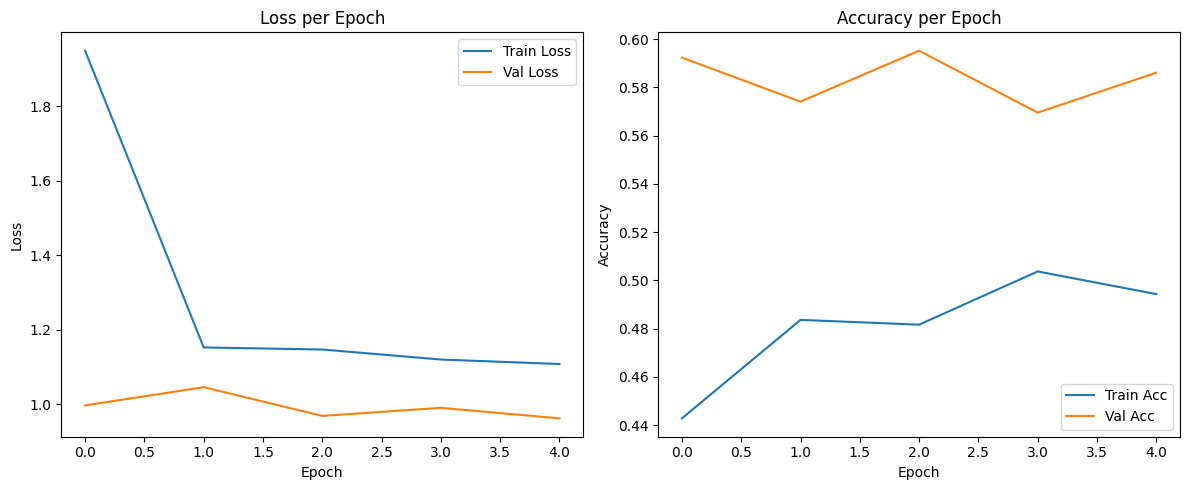

Config {'batch_size': 16, 'lr': 0.001, 'weight_decay': 0.0001} → Val Acc: 0.5844



Epoch 1:
  Train Loss: 1.9614 | Train Acc: 0.4486
  Val   Loss: 0.9688 | Val   Acc: 0.5678
Saved new best model to model_lr0.001_bs16_wd1e-05.pth



Epoch 2:
  Train Loss: 1.1379 | Train Acc: 0.4854
  Val   Loss: 0.9998 | Val   Acc: 0.5650
Saved new best model to model_lr0.001_bs16_wd1e-05.pth



Epoch 3:
  Train Loss: 1.1276 | Train Acc: 0.4583
  Val   Loss: 0.9397 | Val   Acc: 0.5781
Saved new best model to model_lr0.001_bs16_wd1e-05.pth



Epoch 4:
  Train Loss: 1.1042 | Train Acc: 0.4714
  Val   Loss: 1.0240 | Val   Acc: 0.5798
Saved new best model to model_lr0.001_bs16_wd1e-05.pth



Epoch 5:
  Train Loss: 1.1033 | Train Acc: 0.4752
  Val   Loss: 1.0612 | Val   Acc: 0.5644
Saved new best model to model_lr0.001_bs16_wd1e-05.pth


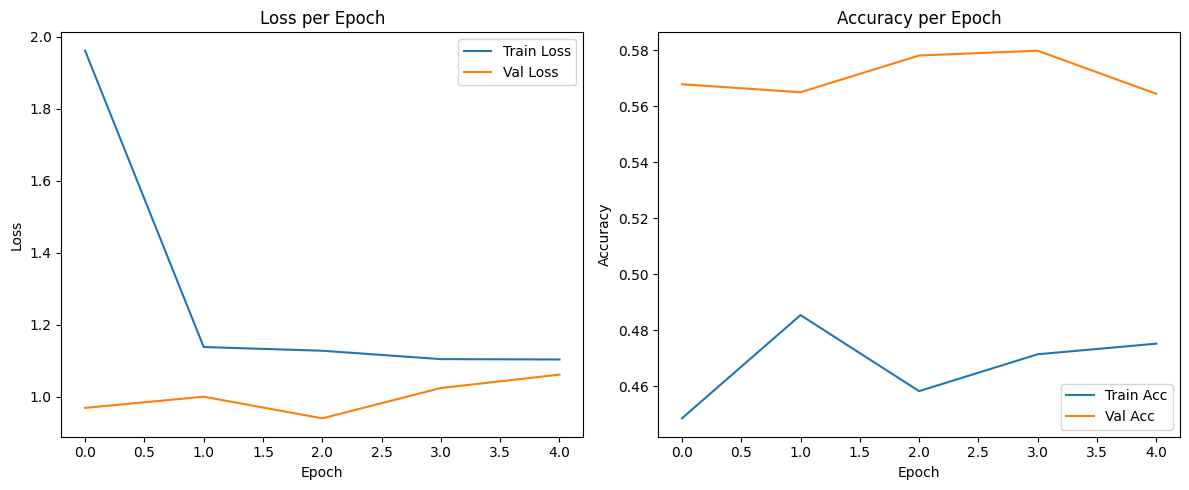

Config {'batch_size': 16, 'lr': 0.001, 'weight_decay': 1e-05} → Val Acc: 0.5587



Epoch 1:
  Train Loss: 2.0857 | Train Acc: 0.4700
  Val   Loss: 1.0007 | Val   Acc: 0.5730
Saved new best model to model_lr0.001_bs16_wd0.001.pth



Epoch 2:
  Train Loss: 1.1005 | Train Acc: 0.5081
  Val   Loss: 0.9174 | Val   Acc: 0.5992
Saved new best model to model_lr0.001_bs16_wd0.001.pth



Epoch 3:
  Train Loss: 1.0635 | Train Acc: 0.5169
  Val   Loss: 1.0256 | Val   Acc: 0.5827
Saved new best model to model_lr0.001_bs16_wd0.001.pth


KeyboardInterrupt: 

In [636]:

param_grid = {
    "lr": [1e-3, 1e-4],
    "batch_size": [16, 32, 64],
    "weight_decay": [1e-4, 1e-5, 0.001]
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results, best_config = hyperparameter_search(
    param_grid=param_grid,
    train_csv="image_data/train.csv",
    valid_csv="image_data/valid.csv",
    test_csv ="image_data/test.csv",
    train_dir="image_data/train_images",
    valid_dir="image_data/valid_images",
    test_dir ="image_data/test_images",
    transform=transform,
    num_epochs=5,
    patience=3,
    device=device
)


Epoch 1:
  Train Loss: 1.5174 | Train Acc: 0.5058
  Val   Loss: 0.9221 | Val   Acc: 0.5952
Saved new best model to best_mri_model.pth



Epoch 2:
  Train Loss: 1.0278 | Train Acc: 0.5476
  Val   Loss: 0.9126 | Val   Acc: 0.6083
Saved new best model to best_mri_model.pth



Epoch 3:
  Train Loss: 1.0020 | Train Acc: 0.5657
  Val   Loss: 0.8110 | Val   Acc: 0.6437
Saved new best model to best_mri_model.pth



Epoch 4:
  Train Loss: 0.9666 | Train Acc: 0.5794
  Val   Loss: 0.8556 | Val   Acc: 0.6277
Saved new best model to best_mri_model.pth



Epoch 5:
  Train Loss: 0.9396 | Train Acc: 0.5866
  Val   Loss: 0.7716 | Val   Acc: 0.6522
Saved new best model to best_mri_model.pth



Epoch 6:
  Train Loss: 0.9241 | Train Acc: 0.5863
  Val   Loss: 0.8248 | Val   Acc: 0.6437
Saved new best model to best_mri_model.pth



Epoch 7:
  Train Loss: 0.9239 | Train Acc: 0.5896
  Val   Loss: 0.8418 | Val   Acc: 0.6363
Saved new best model to best_mri_model.pth



Epoch 8:
  Train Loss: 0.8915 | Train Acc: 0.6031
  Val   Loss: 0.7512 | Val   Acc: 0.6796
Saved new best model to best_mri_model.pth



Epoch 9:
  Train Loss: 0.8979 | Train Acc: 0.6041
  Val   Loss: 0.7493 | Val   Acc: 0.6836
Saved new best model to best_mri_model.pth



Epoch 10:
  Train Loss: 0.8915 | Train Acc: 0.6085
  Val   Loss: 0.7640 | Val   Acc: 0.6784
Saved new best model to best_mri_model.pth



Epoch 11:
  Train Loss: 0.8710 | Train Acc: 0.6034
  Val   Loss: 0.7475 | Val   Acc: 0.6631
Saved new best model to best_mri_model.pth



Epoch 12:
  Train Loss: 0.8655 | Train Acc: 0.6112
  Val   Loss: 0.7492 | Val   Acc: 0.6710
Saved new best model to best_mri_model.pth



Epoch 13:
  Train Loss: 0.8419 | Train Acc: 0.6176
  Val   Loss: 0.7127 | Val   Acc: 0.6824
Saved new best model to best_mri_model.pth



Epoch 14:
  Train Loss: 0.8561 | Train Acc: 0.6166
  Val   Loss: 0.7717 | Val   Acc: 0.6511
Saved new best model to best_mri_model.pth



Epoch 15:
  Train Loss: 0.8439 | Train Acc: 0.6261
  Val   Loss: 0.6463 | Val   Acc: 0.7098
Saved new best model to best_mri_model.pth



Epoch 16:
  Train Loss: 0.8369 | Train Acc: 0.6174
  Val   Loss: 0.7070 | Val   Acc: 0.6739
Saved new best model to best_mri_model.pth



Epoch 17:
  Train Loss: 0.8148 | Train Acc: 0.6377
  Val   Loss: 0.6889 | Val   Acc: 0.7201
Saved new best model to best_mri_model.pth



Epoch 18:
  Train Loss: 0.8153 | Train Acc: 0.6270
  Val   Loss: 0.6688 | Val   Acc: 0.7013
Saved new best model to best_mri_model.pth



Epoch 19:
  Train Loss: 0.8053 | Train Acc: 0.6317
  Val   Loss: 0.6550 | Val   Acc: 0.7121
Saved new best model to best_mri_model.pth



Epoch 20:
  Train Loss: 0.8157 | Train Acc: 0.6212
  Val   Loss: 0.6341 | Val   Acc: 0.7070
Saved new best model to best_mri_model.pth



Epoch 21:
  Train Loss: 0.7947 | Train Acc: 0.6263
  Val   Loss: 0.6232 | Val   Acc: 0.7366
Saved new best model to best_mri_model.pth



Epoch 22:
  Train Loss: 0.8042 | Train Acc: 0.6227
  Val   Loss: 0.6295 | Val   Acc: 0.7075
Saved new best model to best_mri_model.pth



Epoch 23:
  Train Loss: 0.7847 | Train Acc: 0.6337
  Val   Loss: 0.6454 | Val   Acc: 0.7138
Saved new best model to best_mri_model.pth



Epoch 24:
  Train Loss: 0.7693 | Train Acc: 0.6368
  Val   Loss: 0.5893 | Val   Acc: 0.7081
Saved new best model to best_mri_model.pth



Epoch 25:
  Train Loss: 0.7747 | Train Acc: 0.6370
  Val   Loss: 0.7153 | Val   Acc: 0.6773
Saved new best model to best_mri_model.pth



Epoch 26:
  Train Loss: 0.7629 | Train Acc: 0.6451
  Val   Loss: 0.5792 | Val   Acc: 0.7429
Saved new best model to best_mri_model.pth



Epoch 27:
  Train Loss: 0.7483 | Train Acc: 0.6485
  Val   Loss: 0.5273 | Val   Acc: 0.7611
Saved new best model to best_mri_model.pth



Epoch 28:
  Train Loss: 0.7363 | Train Acc: 0.6561
  Val   Loss: 0.5280 | Val   Acc: 0.7651
Saved new best model to best_mri_model.pth



Epoch 29:
  Train Loss: 0.7320 | Train Acc: 0.6633
  Val   Loss: 0.5316 | Val   Acc: 0.7919
Saved new best model to best_mri_model.pth



Epoch 30:
  Train Loss: 0.7241 | Train Acc: 0.6709
  Val   Loss: 0.5415 | Val   Acc: 0.7628
Saved new best model to best_mri_model.pth



Epoch 31:
  Train Loss: 0.7203 | Train Acc: 0.6709
  Val   Loss: 0.5525 | Val   Acc: 0.7782
Saved new best model to best_mri_model.pth



Epoch 32:
  Train Loss: 0.7081 | Train Acc: 0.6734
  Val   Loss: 0.5637 | Val   Acc: 0.7799
Saved new best model to best_mri_model.pth



Epoch 33:
  Train Loss: 0.6849 | Train Acc: 0.6938
  Val   Loss: 0.4669 | Val   Acc: 0.8170
Saved new best model to best_mri_model.pth



Epoch 34:
  Train Loss: 0.7149 | Train Acc: 0.6704
  Val   Loss: 0.5657 | Val   Acc: 0.7132
Saved new best model to best_mri_model.pth



Epoch 35:
  Train Loss: 0.6841 | Train Acc: 0.6929
  Val   Loss: 0.4953 | Val   Acc: 0.7469
Saved new best model to best_mri_model.pth



Epoch 36:
  Train Loss: 0.6751 | Train Acc: 0.6962
  Val   Loss: 0.4808 | Val   Acc: 0.7851
Saved new best model to best_mri_model.pth



Epoch 37:
  Train Loss: 0.6655 | Train Acc: 0.7020
  Val   Loss: 0.4954 | Val   Acc: 0.7913
Saved new best model to best_mri_model.pth



Epoch 38:
  Train Loss: 0.6781 | Train Acc: 0.7000
  Val   Loss: 0.4373 | Val   Acc: 0.8193
Saved new best model to best_mri_model.pth



Epoch 39:
  Train Loss: 0.6638 | Train Acc: 0.7033
  Val   Loss: 0.5027 | Val   Acc: 0.7702
Saved new best model to best_mri_model.pth



Epoch 40:
  Train Loss: 0.6605 | Train Acc: 0.7066
  Val   Loss: 0.4493 | Val   Acc: 0.8062
Saved new best model to best_mri_model.pth



Epoch 41:
  Train Loss: 0.6503 | Train Acc: 0.7122
  Val   Loss: 0.4563 | Val   Acc: 0.8062
Saved new best model to best_mri_model.pth



Epoch 42:
  Train Loss: 0.6238 | Train Acc: 0.7224
  Val   Loss: 0.4414 | Val   Acc: 0.8096
Saved new best model to best_mri_model.pth



Epoch 43:
  Train Loss: 0.6409 | Train Acc: 0.7160
  Val   Loss: 0.4540 | Val   Acc: 0.8147
Saved new best model to best_mri_model.pth



Epoch 44:
  Train Loss: 0.6364 | Train Acc: 0.7219
  Val   Loss: 0.4310 | Val   Acc: 0.8176
Saved new best model to best_mri_model.pth



Epoch 45:
  Train Loss: 0.6409 | Train Acc: 0.7211
  Val   Loss: 0.4264 | Val   Acc: 0.8432
Saved new best model to best_mri_model.pth



Epoch 46:
  Train Loss: 0.6150 | Train Acc: 0.7254
  Val   Loss: 0.4232 | Val   Acc: 0.8455
Saved new best model to best_mri_model.pth



Epoch 47:
  Train Loss: 0.6296 | Train Acc: 0.7270
  Val   Loss: 0.4494 | Val   Acc: 0.7885
Saved new best model to best_mri_model.pth



Epoch 48:
  Train Loss: 0.5993 | Train Acc: 0.7314
  Val   Loss: 0.4077 | Val   Acc: 0.8301
Saved new best model to best_mri_model.pth



Epoch 49:
  Train Loss: 0.6167 | Train Acc: 0.7282
  Val   Loss: 0.3770 | Val   Acc: 0.8529
Saved new best model to best_mri_model.pth



Epoch 50:
  Train Loss: 0.6203 | Train Acc: 0.7235
  Val   Loss: 0.4054 | Val   Acc: 0.8398
Saved new best model to best_mri_model.pth


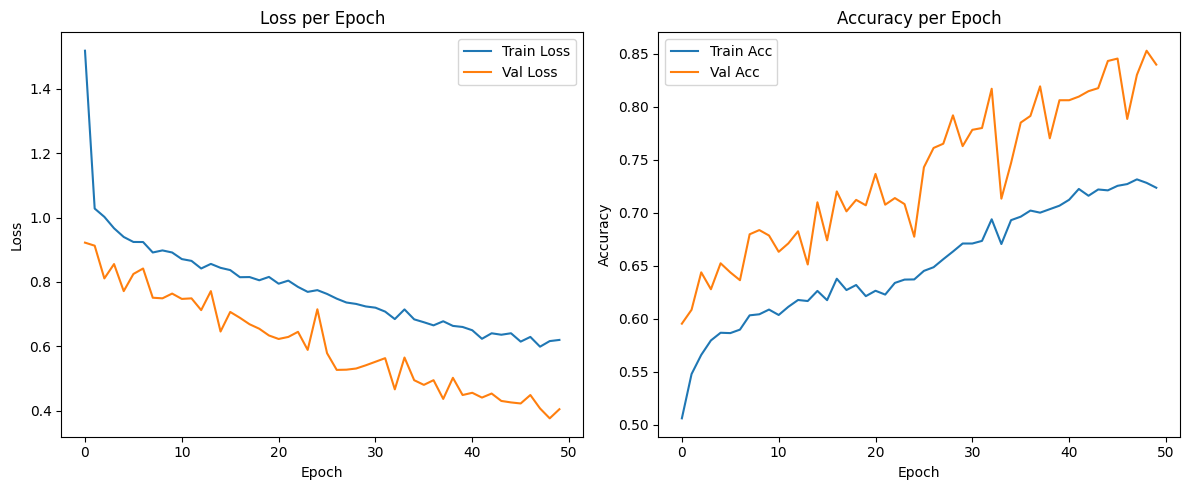


 Test Loss: 0.4163 | Test Accuracy: 0.8305


In [611]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = MRIDataset("image_data/train_images", "image_data/train.csv", transform=transform)
valid_dataset = MRIDataset("image_data/valid_images", "image_data/valid.csv", transform=transform)
test_dataset = MRIDataset("image_data/test_images", "image_data/test.csv", transform=transform)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# edit according to best config and modify epochs 
model = MRICNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)


train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=50, patience=0)
evaluate_on_test(model, test_loader, criterion, model_path="best_mri_model.pth")   # Evaluate on test



Epoch 1:
  Train Loss: 2.0100 | Train Acc: 0.4919
  Val   Loss: 1.0286 | Val   Acc: 0.5182
Saved new best model to best_mri_model.pth



Epoch 2:
  Train Loss: 1.1197 | Train Acc: 0.4930
  Val   Loss: 0.9353 | Val   Acc: 0.5701
Saved new best model to best_mri_model.pth



Epoch 3:
  Train Loss: 1.0624 | Train Acc: 0.5221
  Val   Loss: 0.9325 | Val   Acc: 0.5946
Saved new best model to best_mri_model.pth



Epoch 4:
  Train Loss: 1.0455 | Train Acc: 0.5299
  Val   Loss: 0.8872 | Val   Acc: 0.6203
Saved new best model to best_mri_model.pth



Epoch 5:
  Train Loss: 1.0578 | Train Acc: 0.5160
  Val   Loss: 0.8834 | Val   Acc: 0.6135
Saved new best model to best_mri_model.pth



Epoch 6:
  Train Loss: 1.0354 | Train Acc: 0.5406
  Val   Loss: 0.8635 | Val   Acc: 0.6152
Saved new best model to best_mri_model.pth



Epoch 7:
  Train Loss: 1.0283 | Train Acc: 0.5379
  Val   Loss: 0.8838 | Val   Acc: 0.6129
Saved new best model to best_mri_model.pth



Epoch 8:
  Train Loss: 1.0153 | Train Acc: 0.5409
  Val   Loss: 0.7962 | Val   Acc: 0.6397
Saved new best model to best_mri_model.pth



Epoch 9:
  Train Loss: 0.9757 | Train Acc: 0.5611
  Val   Loss: 0.7687 | Val   Acc: 0.6505
Saved new best model to best_mri_model.pth



Epoch 10:
  Train Loss: 0.9480 | Train Acc: 0.5791
  Val   Loss: 0.8128 | Val   Acc: 0.6585
Saved new best model to best_mri_model.pth



Epoch 11:
  Train Loss: 0.9299 | Train Acc: 0.5866
  Val   Loss: 0.7875 | Val   Acc: 0.6117
Saved new best model to best_mri_model.pth



Epoch 12:
  Train Loss: 0.9276 | Train Acc: 0.5850
  Val   Loss: 0.7616 | Val   Acc: 0.6499
Saved new best model to best_mri_model.pth



Epoch 13:
  Train Loss: 0.9160 | Train Acc: 0.5891
  Val   Loss: 0.7481 | Val   Acc: 0.6534
Saved new best model to best_mri_model.pth



Epoch 14:
  Train Loss: 0.9003 | Train Acc: 0.5995
  Val   Loss: 0.7708 | Val   Acc: 0.6517
Saved new best model to best_mri_model.pth



Epoch 15:
  Train Loss: 0.8808 | Train Acc: 0.6057
  Val   Loss: 0.7483 | Val   Acc: 0.6784
Saved new best model to best_mri_model.pth



Epoch 16:
  Train Loss: 0.8801 | Train Acc: 0.6070
  Val   Loss: 0.7074 | Val   Acc: 0.6705
Saved new best model to best_mri_model.pth



Epoch 17:
  Train Loss: 0.8684 | Train Acc: 0.6085
  Val   Loss: 0.6748 | Val   Acc: 0.6819
Saved new best model to best_mri_model.pth



Epoch 18:
  Train Loss: 0.8483 | Train Acc: 0.6172
  Val   Loss: 0.7263 | Val   Acc: 0.6739
Saved new best model to best_mri_model.pth



Epoch 19:
  Train Loss: 0.8389 | Train Acc: 0.6273
  Val   Loss: 0.7093 | Val   Acc: 0.6830
Saved new best model to best_mri_model.pth



Epoch 20:
  Train Loss: 0.8382 | Train Acc: 0.6210
  Val   Loss: 0.6747 | Val   Acc: 0.6938
Saved new best model to best_mri_model.pth



Epoch 21:
  Train Loss: 0.8346 | Train Acc: 0.6261
  Val   Loss: 0.6704 | Val   Acc: 0.6893
Saved new best model to best_mri_model.pth



Epoch 22:
  Train Loss: 0.8106 | Train Acc: 0.6353
  Val   Loss: 0.6738 | Val   Acc: 0.6984
Saved new best model to best_mri_model.pth



Epoch 23:
  Train Loss: 0.7983 | Train Acc: 0.6414
  Val   Loss: 0.6233 | Val   Acc: 0.6927
Saved new best model to best_mri_model.pth



Epoch 24:
  Train Loss: 0.7823 | Train Acc: 0.6528
  Val   Loss: 0.6559 | Val   Acc: 0.7013
Saved new best model to best_mri_model.pth



Epoch 25:
  Train Loss: 0.7721 | Train Acc: 0.6592
  Val   Loss: 0.6343 | Val   Acc: 0.7132
Saved new best model to best_mri_model.pth



Epoch 26:
  Train Loss: 0.7637 | Train Acc: 0.6569
  Val   Loss: 0.6404 | Val   Acc: 0.6790
Saved new best model to best_mri_model.pth



Epoch 27:
  Train Loss: 0.7377 | Train Acc: 0.6615
  Val   Loss: 0.5778 | Val   Acc: 0.7172
Saved new best model to best_mri_model.pth



Epoch 28:
  Train Loss: 0.7200 | Train Acc: 0.6696
  Val   Loss: 0.5268 | Val   Acc: 0.7514
Saved new best model to best_mri_model.pth



Epoch 29:
  Train Loss: 0.7061 | Train Acc: 0.6903
  Val   Loss: 0.5065 | Val   Acc: 0.7828
Saved new best model to best_mri_model.pth



Epoch 30:
  Train Loss: 0.6839 | Train Acc: 0.7002
  Val   Loss: 0.5384 | Val   Acc: 0.7982
Saved new best model to best_mri_model.pth



Epoch 31:
  Train Loss: 0.6571 | Train Acc: 0.7168
  Val   Loss: 0.5558 | Val   Acc: 0.7691
Saved new best model to best_mri_model.pth



Epoch 32:
  Train Loss: 0.6422 | Train Acc: 0.7180
  Val   Loss: 0.5077 | Val   Acc: 0.7959
Saved new best model to best_mri_model.pth



Epoch 33:
  Train Loss: 0.6317 | Train Acc: 0.7199
  Val   Loss: 0.4722 | Val   Acc: 0.8119
Saved new best model to best_mri_model.pth



Epoch 34:
  Train Loss: 0.6051 | Train Acc: 0.7300
  Val   Loss: 0.5002 | Val   Acc: 0.7948
Saved new best model to best_mri_model.pth



Epoch 35:
  Train Loss: 0.5827 | Train Acc: 0.7440
  Val   Loss: 0.4763 | Val   Acc: 0.7896
Saved new best model to best_mri_model.pth



Epoch 36:
  Train Loss: 0.5730 | Train Acc: 0.7599
  Val   Loss: 0.4086 | Val   Acc: 0.8461
Saved new best model to best_mri_model.pth



Epoch 37:
  Train Loss: 0.5782 | Train Acc: 0.7538
  Val   Loss: 0.3895 | Val   Acc: 0.8495
Saved new best model to best_mri_model.pth



Epoch 38:
  Train Loss: 0.5543 | Train Acc: 0.7593
  Val   Loss: 0.4383 | Val   Acc: 0.8438
Saved new best model to best_mri_model.pth



Epoch 39:
  Train Loss: 0.5301 | Train Acc: 0.7721
  Val   Loss: 0.3886 | Val   Acc: 0.8552
Saved new best model to best_mri_model.pth



Epoch 40:
  Train Loss: 0.5099 | Train Acc: 0.7853
  Val   Loss: 0.3948 | Val   Acc: 0.8444
Saved new best model to best_mri_model.pth



Epoch 41:
  Train Loss: 0.4889 | Train Acc: 0.8007
  Val   Loss: 0.3549 | Val   Acc: 0.8706
Saved new best model to best_mri_model.pth



Epoch 42:
  Train Loss: 0.4867 | Train Acc: 0.7961
  Val   Loss: 0.3219 | Val   Acc: 0.8797
Saved new best model to best_mri_model.pth



Epoch 43:
  Train Loss: 0.4665 | Train Acc: 0.8050
  Val   Loss: 0.3150 | Val   Acc: 0.8848
Saved new best model to best_mri_model.pth



Epoch 44:
  Train Loss: 0.4592 | Train Acc: 0.8103
  Val   Loss: 0.3284 | Val   Acc: 0.8826
Saved new best model to best_mri_model.pth



Epoch 45:
  Train Loss: 0.4429 | Train Acc: 0.8169
  Val   Loss: 0.2804 | Val   Acc: 0.8985
Saved new best model to best_mri_model.pth



Epoch 46:
  Train Loss: 0.4250 | Train Acc: 0.8294
  Val   Loss: 0.2858 | Val   Acc: 0.8962
Saved new best model to best_mri_model.pth



Epoch 47:
  Train Loss: 0.4098 | Train Acc: 0.8384
  Val   Loss: 0.3667 | Val   Acc: 0.8774
Saved new best model to best_mri_model.pth



Epoch 48:
  Train Loss: 0.3934 | Train Acc: 0.8466
  Val   Loss: 0.2691 | Val   Acc: 0.9054
Saved new best model to best_mri_model.pth



Epoch 49:
  Train Loss: 0.3690 | Train Acc: 0.8539
  Val   Loss: 0.2769 | Val   Acc: 0.9054
Saved new best model to best_mri_model.pth



Epoch 50:
  Train Loss: 0.3913 | Train Acc: 0.8456
  Val   Loss: 0.2673 | Val   Acc: 0.9082
Saved new best model to best_mri_model.pth


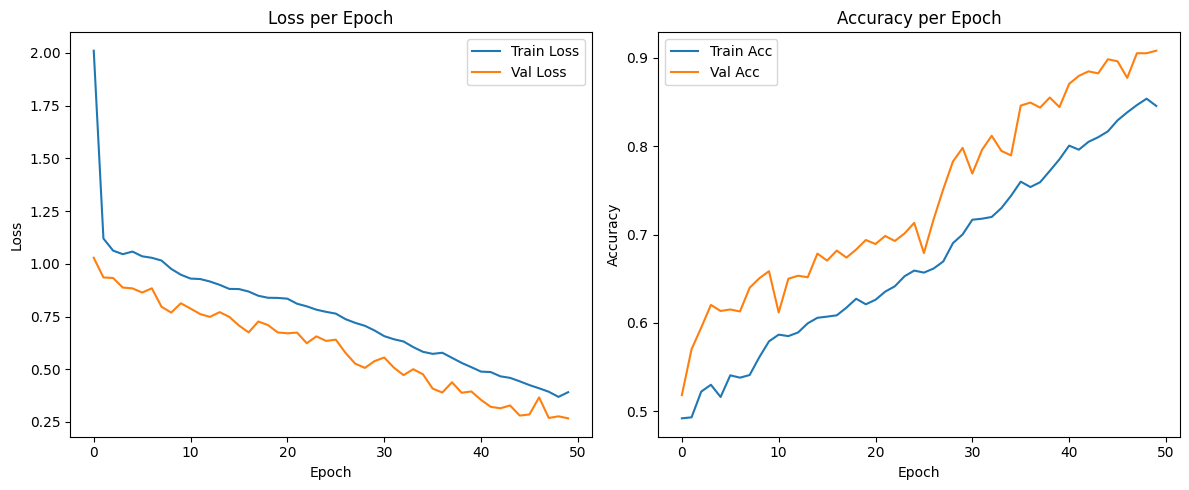


 Test Loss: 0.2974 | Test Accuracy: 0.8958


In [612]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = MRIDataset("image_data/train_images", "image_data/train.csv", transform=transform)
valid_dataset = MRIDataset("image_data/valid_images", "image_data/valid.csv", transform=transform)
test_dataset = MRIDataset("image_data/test_images", "image_data/test.csv", transform=transform)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# edit according to best config and modify epochs 
model = MRICNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)


train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=50, patience=0)
evaluate_on_test(model, test_loader, criterion, model_path="best_mri_model.pth")   # Evaluate on test



Epoch 1:
  Train Loss: 1.1119 | Train Acc: 0.5529
  Val   Loss: 0.8197 | Val   Acc: 0.6317
Saved new best model to best_mri_model.pth



Epoch 2:
  Train Loss: 0.8894 | Train Acc: 0.6135
  Val   Loss: 0.7459 | Val   Acc: 0.6693
Saved new best model to best_mri_model.pth



Epoch 3:
  Train Loss: 0.8249 | Train Acc: 0.6475
  Val   Loss: 0.7263 | Val   Acc: 0.6836
Saved new best model to best_mri_model.pth



Epoch 4:
  Train Loss: 0.7742 | Train Acc: 0.6620
  Val   Loss: 0.6593 | Val   Acc: 0.7047
Saved new best model to best_mri_model.pth



Epoch 5:
  Train Loss: 0.7394 | Train Acc: 0.6814
  Val   Loss: 0.6094 | Val   Acc: 0.7275
Saved new best model to best_mri_model.pth



Epoch 6:
  Train Loss: 0.7195 | Train Acc: 0.6896
  Val   Loss: 0.6170 | Val   Acc: 0.7206
Saved new best model to best_mri_model.pth



Epoch 7:
  Train Loss: 0.6866 | Train Acc: 0.7017
  Val   Loss: 0.5705 | Val   Acc: 0.7497
Saved new best model to best_mri_model.pth



Epoch 8:
  Train Loss: 0.6487 | Train Acc: 0.7188
  Val   Loss: 0.5948 | Val   Acc: 0.7275
Saved new best model to best_mri_model.pth



Epoch 9:
  Train Loss: 0.6217 | Train Acc: 0.7316
  Val   Loss: 0.5568 | Val   Acc: 0.7765
Saved new best model to best_mri_model.pth



Epoch 10:
  Train Loss: 0.6199 | Train Acc: 0.7278
  Val   Loss: 0.5093 | Val   Acc: 0.7702
Saved new best model to best_mri_model.pth



Epoch 11:
  Train Loss: 0.6126 | Train Acc: 0.7370
  Val   Loss: 0.4828 | Val   Acc: 0.7970
Saved new best model to best_mri_model.pth



Epoch 12:
  Train Loss: 0.5755 | Train Acc: 0.7540
  Val   Loss: 0.4667 | Val   Acc: 0.8050
Saved new best model to best_mri_model.pth



Epoch 13:
  Train Loss: 0.5646 | Train Acc: 0.7571
  Val   Loss: 0.5044 | Val   Acc: 0.7965
Saved new best model to best_mri_model.pth



Epoch 14:
  Train Loss: 0.5521 | Train Acc: 0.7657
  Val   Loss: 0.4753 | Val   Acc: 0.8238
Saved new best model to best_mri_model.pth



Epoch 15:
  Train Loss: 0.5360 | Train Acc: 0.7731
  Val   Loss: 0.4658 | Val   Acc: 0.8141
Saved new best model to best_mri_model.pth



Epoch 16:
  Train Loss: 0.5325 | Train Acc: 0.7782
  Val   Loss: 0.4373 | Val   Acc: 0.8341
Saved new best model to best_mri_model.pth



Epoch 17:
  Train Loss: 0.5131 | Train Acc: 0.7892
  Val   Loss: 0.5850 | Val   Acc: 0.8005
Saved new best model to best_mri_model.pth



Epoch 18:
  Train Loss: 0.4994 | Train Acc: 0.7999
  Val   Loss: 0.4545 | Val   Acc: 0.8261
Saved new best model to best_mri_model.pth



Epoch 19:
  Train Loss: 0.4958 | Train Acc: 0.7910
  Val   Loss: 0.3952 | Val   Acc: 0.8518
Saved new best model to best_mri_model.pth



Epoch 20:
  Train Loss: 0.4783 | Train Acc: 0.8039
  Val   Loss: 0.4128 | Val   Acc: 0.8432
Saved new best model to best_mri_model.pth



Epoch 21:
  Train Loss: 0.4719 | Train Acc: 0.8030
  Val   Loss: 0.4993 | Val   Acc: 0.7982
Saved new best model to best_mri_model.pth



Epoch 22:
  Train Loss: 0.4715 | Train Acc: 0.8071
  Val   Loss: 0.3680 | Val   Acc: 0.8518
Saved new best model to best_mri_model.pth



Epoch 23:
  Train Loss: 0.4695 | Train Acc: 0.8052
  Val   Loss: 0.3710 | Val   Acc: 0.8655
Saved new best model to best_mri_model.pth



Epoch 24:
  Train Loss: 0.4453 | Train Acc: 0.8149
  Val   Loss: 0.3491 | Val   Acc: 0.8643
Saved new best model to best_mri_model.pth



Epoch 25:
  Train Loss: 0.4416 | Train Acc: 0.8160
  Val   Loss: 0.3404 | Val   Acc: 0.8729
Saved new best model to best_mri_model.pth



Epoch 26:
  Train Loss: 0.4422 | Train Acc: 0.8145
  Val   Loss: 0.3799 | Val   Acc: 0.8540
Saved new best model to best_mri_model.pth



Epoch 27:
  Train Loss: 0.4318 | Train Acc: 0.8216
  Val   Loss: 0.3896 | Val   Acc: 0.8523
Saved new best model to best_mri_model.pth



Epoch 28:
  Train Loss: 0.4282 | Train Acc: 0.8243
  Val   Loss: 0.3430 | Val   Acc: 0.8649
Saved new best model to best_mri_model.pth



Epoch 29:
  Train Loss: 0.4324 | Train Acc: 0.8231
  Val   Loss: 0.3665 | Val   Acc: 0.8563
Saved new best model to best_mri_model.pth



Epoch 30:
  Train Loss: 0.4206 | Train Acc: 0.8244
  Val   Loss: 0.3244 | Val   Acc: 0.8769
Saved new best model to best_mri_model.pth



Epoch 31:
  Train Loss: 0.4215 | Train Acc: 0.8331
  Val   Loss: 0.3272 | Val   Acc: 0.8808
Saved new best model to best_mri_model.pth



Epoch 32:
  Train Loss: 0.4008 | Train Acc: 0.8396
  Val   Loss: 0.3176 | Val   Acc: 0.8780
Saved new best model to best_mri_model.pth



Epoch 33:
  Train Loss: 0.4020 | Train Acc: 0.8386
  Val   Loss: 0.3230 | Val   Acc: 0.8786
Saved new best model to best_mri_model.pth



Epoch 34:
  Train Loss: 0.4006 | Train Acc: 0.8377
  Val   Loss: 0.3209 | Val   Acc: 0.8763
Saved new best model to best_mri_model.pth



Epoch 35:
  Train Loss: 0.4054 | Train Acc: 0.8351
  Val   Loss: 0.3033 | Val   Acc: 0.8831
Saved new best model to best_mri_model.pth



Epoch 36:
  Train Loss: 0.4045 | Train Acc: 0.8350
  Val   Loss: 0.3130 | Val   Acc: 0.8746
Saved new best model to best_mri_model.pth



Epoch 37:
  Train Loss: 0.3840 | Train Acc: 0.8481
  Val   Loss: 0.3144 | Val   Acc: 0.8865
Saved new best model to best_mri_model.pth



Epoch 38:
  Train Loss: 0.3870 | Train Acc: 0.8476
  Val   Loss: 0.2912 | Val   Acc: 0.8905
Saved new best model to best_mri_model.pth



Epoch 39:
  Train Loss: 0.3836 | Train Acc: 0.8460
  Val   Loss: 0.3266 | Val   Acc: 0.8700
Saved new best model to best_mri_model.pth



Epoch 40:
  Train Loss: 0.3669 | Train Acc: 0.8514
  Val   Loss: 0.3126 | Val   Acc: 0.8763
Saved new best model to best_mri_model.pth



Epoch 41:
  Train Loss: 0.3731 | Train Acc: 0.8442
  Val   Loss: 0.2941 | Val   Acc: 0.8905
Saved new best model to best_mri_model.pth



Epoch 42:
  Train Loss: 0.3728 | Train Acc: 0.8496
  Val   Loss: 0.3055 | Val   Acc: 0.8888
Saved new best model to best_mri_model.pth



Epoch 43:
  Train Loss: 0.3721 | Train Acc: 0.8540
  Val   Loss: 0.2921 | Val   Acc: 0.8911
Saved new best model to best_mri_model.pth



Epoch 44:
  Train Loss: 0.3625 | Train Acc: 0.8488
  Val   Loss: 0.3031 | Val   Acc: 0.8774
Saved new best model to best_mri_model.pth



Epoch 45:
  Train Loss: 0.3512 | Train Acc: 0.8585
  Val   Loss: 0.2628 | Val   Acc: 0.9048
Saved new best model to best_mri_model.pth



Epoch 46:
  Train Loss: 0.3657 | Train Acc: 0.8450
  Val   Loss: 0.2857 | Val   Acc: 0.8894
Saved new best model to best_mri_model.pth



Epoch 47:
  Train Loss: 0.3562 | Train Acc: 0.8578
  Val   Loss: 0.4140 | Val   Acc: 0.8369
Saved new best model to best_mri_model.pth



Epoch 48:
  Train Loss: 0.3510 | Train Acc: 0.8598
  Val   Loss: 0.2683 | Val   Acc: 0.9008
Saved new best model to best_mri_model.pth



Epoch 49:
  Train Loss: 0.3430 | Train Acc: 0.8590
  Val   Loss: 0.2909 | Val   Acc: 0.8865
Saved new best model to best_mri_model.pth



Epoch 50:
  Train Loss: 0.3464 | Train Acc: 0.8633
  Val   Loss: 0.2650 | Val   Acc: 0.8883
Saved new best model to best_mri_model.pth


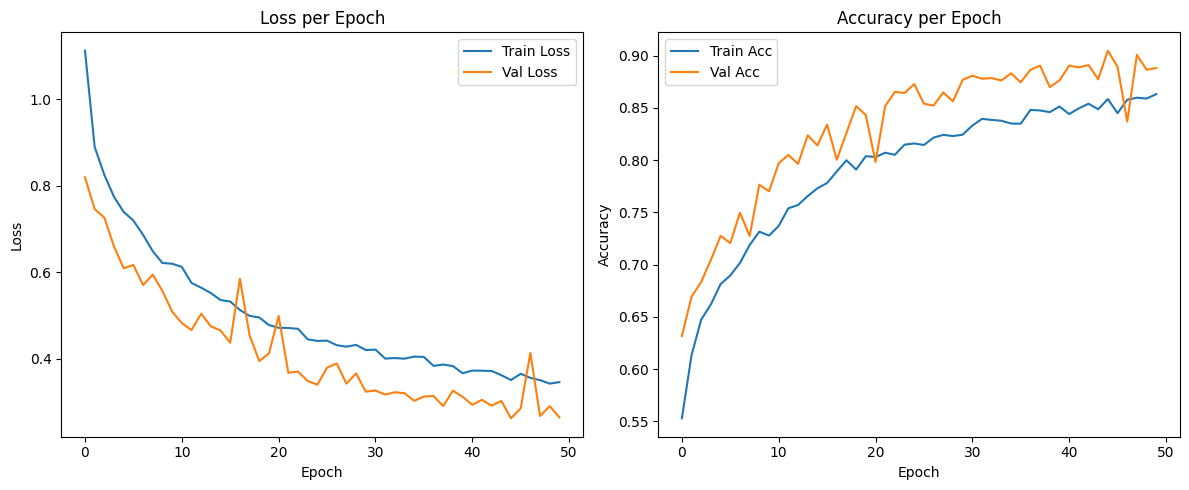


 Test Loss: 0.2896 | Test Accuracy: 0.8981


In [614]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = MRIDataset("image_data/train_images", "image_data/train.csv", transform=transform)
valid_dataset = MRIDataset("image_data/valid_images", "image_data/valid.csv", transform=transform)
test_dataset = MRIDataset("image_data/test_images", "image_data/test.csv", transform=transform)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# edit according to best config and modify epochs 
model = MRICNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)


train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=50, patience=3)
evaluate_on_test(model, test_loader, criterion, model_path="best_mri_model.pth")   # Evaluate on test



Epoch 1:
  Train Loss: 0.8994 | Train Acc: 0.6352
  Val   Loss: 0.5927 | Val   Acc: 0.7520
Saved new best model to best_mri_model.pth



Epoch 2:
  Train Loss: 0.5960 | Train Acc: 0.7495
  Val   Loss: 0.4784 | Val   Acc: 0.8136
Saved new best model to best_mri_model.pth



Epoch 3:
  Train Loss: 0.4656 | Train Acc: 0.8119
  Val   Loss: 0.3927 | Val   Acc: 0.8375
Saved new best model to best_mri_model.pth



Epoch 4:
  Train Loss: 0.3900 | Train Acc: 0.8427
  Val   Loss: 0.2989 | Val   Acc: 0.8803
Saved new best model to best_mri_model.pth



Epoch 5:
  Train Loss: 0.3016 | Train Acc: 0.8870
  Val   Loss: 0.2541 | Val   Acc: 0.9105
Saved new best model to best_mri_model.pth



Epoch 6:
  Train Loss: 0.2632 | Train Acc: 0.8983
  Val   Loss: 0.2219 | Val   Acc: 0.9270
Saved new best model to best_mri_model.pth



Epoch 7:
  Train Loss: 0.2344 | Train Acc: 0.9077
  Val   Loss: 0.2718 | Val   Acc: 0.8985
Saved new best model to best_mri_model.pth



Epoch 8:
  Train Loss: 0.2082 | Train Acc: 0.9230
  Val   Loss: 0.1944 | Val   Acc: 0.9322
Saved new best model to best_mri_model.pth



Epoch 9:
  Train Loss: 0.1687 | Train Acc: 0.9337
  Val   Loss: 0.2022 | Val   Acc: 0.9356
Saved new best model to best_mri_model.pth



Epoch 10:
  Train Loss: 0.1647 | Train Acc: 0.9327
  Val   Loss: 0.2092 | Val   Acc: 0.9270
Saved new best model to best_mri_model.pth



Epoch 11:
  Train Loss: 0.1352 | Train Acc: 0.9500
  Val   Loss: 0.1646 | Val   Acc: 0.9493
Saved new best model to best_mri_model.pth



Epoch 12:
  Train Loss: 0.1163 | Train Acc: 0.9538
  Val   Loss: 0.2443 | Val   Acc: 0.9230
Saved new best model to best_mri_model.pth



Epoch 13:
  Train Loss: 0.1277 | Train Acc: 0.9524
  Val   Loss: 0.1575 | Val   Acc: 0.9561
Saved new best model to best_mri_model.pth



Epoch 14:
  Train Loss: 0.1130 | Train Acc: 0.9569
  Val   Loss: 0.1288 | Val   Acc: 0.9647
Saved new best model to best_mri_model.pth



Epoch 15:
  Train Loss: 0.1093 | Train Acc: 0.9580
  Val   Loss: 0.1533 | Val   Acc: 0.9510
Saved new best model to best_mri_model.pth



Epoch 16:
  Train Loss: 0.0930 | Train Acc: 0.9626
  Val   Loss: 0.1530 | Val   Acc: 0.9641
Saved new best model to best_mri_model.pth



Epoch 17:
  Train Loss: 0.0919 | Train Acc: 0.9649
  Val   Loss: 0.1708 | Val   Acc: 0.9624
Saved new best model to best_mri_model.pth



Epoch 18:
  Train Loss: 0.0824 | Train Acc: 0.9661
  Val   Loss: 0.1517 | Val   Acc: 0.9635
Saved new best model to best_mri_model.pth



Epoch 19:
  Train Loss: 0.0703 | Train Acc: 0.9715
  Val   Loss: 0.1480 | Val   Acc: 0.9641
Saved new best model to best_mri_model.pth



Epoch 20:
  Train Loss: 0.0715 | Train Acc: 0.9704
  Val   Loss: 0.1459 | Val   Acc: 0.9647
Saved new best model to best_mri_model.pth



Epoch 21:
  Train Loss: 0.0813 | Train Acc: 0.9702
  Val   Loss: 0.1716 | Val   Acc: 0.9550
Saved new best model to best_mri_model.pth



Epoch 22:
  Train Loss: 0.0836 | Train Acc: 0.9674
  Val   Loss: 0.1613 | Val   Acc: 0.9618
Saved new best model to best_mri_model.pth



Epoch 23:
  Train Loss: 0.0702 | Train Acc: 0.9724
  Val   Loss: 0.1481 | Val   Acc: 0.9658
Saved new best model to best_mri_model.pth



Epoch 24:
  Train Loss: 0.0660 | Train Acc: 0.9738
  Val   Loss: 0.1609 | Val   Acc: 0.9658
Saved new best model to best_mri_model.pth



Epoch 25:
  Train Loss: 0.0594 | Train Acc: 0.9768
  Val   Loss: 0.1509 | Val   Acc: 0.9692
Saved new best model to best_mri_model.pth



Epoch 26:
  Train Loss: 0.0608 | Train Acc: 0.9779
  Val   Loss: 0.1204 | Val   Acc: 0.9743
Saved new best model to best_mri_model.pth



Epoch 27:
  Train Loss: 0.0689 | Train Acc: 0.9728
  Val   Loss: 0.1664 | Val   Acc: 0.9629
Saved new best model to best_mri_model.pth



Epoch 28:
  Train Loss: 0.0542 | Train Acc: 0.9794
  Val   Loss: 0.1603 | Val   Acc: 0.9743
Saved new best model to best_mri_model.pth



Epoch 29:
  Train Loss: 0.0551 | Train Acc: 0.9788
  Val   Loss: 0.1695 | Val   Acc: 0.9715
Saved new best model to best_mri_model.pth



Epoch 30:
  Train Loss: 0.0573 | Train Acc: 0.9756
  Val   Loss: 0.1842 | Val   Acc: 0.9601
Saved new best model to best_mri_model.pth



Epoch 31:
  Train Loss: 0.0524 | Train Acc: 0.9779
  Val   Loss: 0.1322 | Val   Acc: 0.9732
Saved new best model to best_mri_model.pth



Epoch 32:
  Train Loss: 0.0509 | Train Acc: 0.9786
  Val   Loss: 0.1694 | Val   Acc: 0.9704
Saved new best model to best_mri_model.pth



Epoch 33:
  Train Loss: 0.0491 | Train Acc: 0.9796
  Val   Loss: 0.1850 | Val   Acc: 0.9607
Saved new best model to best_mri_model.pth



Epoch 34:
  Train Loss: 0.0574 | Train Acc: 0.9778
  Val   Loss: 0.1739 | Val   Acc: 0.9669
Saved new best model to best_mri_model.pth



Epoch 35:
  Train Loss: 0.0627 | Train Acc: 0.9758
  Val   Loss: 0.1458 | Val   Acc: 0.9704
Saved new best model to best_mri_model.pth



Epoch 36:
  Train Loss: 0.0503 | Train Acc: 0.9786
  Val   Loss: 0.1371 | Val   Acc: 0.9732
Saved new best model to best_mri_model.pth



Epoch 37:
  Train Loss: 0.0413 | Train Acc: 0.9835
  Val   Loss: 0.1545 | Val   Acc: 0.9698
Saved new best model to best_mri_model.pth



Epoch 38:
  Train Loss: 0.0470 | Train Acc: 0.9801
  Val   Loss: 0.1570 | Val   Acc: 0.9709
Saved new best model to best_mri_model.pth



Epoch 39:
  Train Loss: 0.0498 | Train Acc: 0.9784
  Val   Loss: 0.1624 | Val   Acc: 0.9721
Saved new best model to best_mri_model.pth



Epoch 40:
  Train Loss: 0.0390 | Train Acc: 0.9827
  Val   Loss: 0.1749 | Val   Acc: 0.9738
Saved new best model to best_mri_model.pth



Epoch 41:
  Train Loss: 0.0400 | Train Acc: 0.9834
  Val   Loss: 0.1504 | Val   Acc: 0.9732
Saved new best model to best_mri_model.pth



Epoch 42:
  Train Loss: 0.0385 | Train Acc: 0.9832
  Val   Loss: 0.2041 | Val   Acc: 0.9726
Saved new best model to best_mri_model.pth



Epoch 43:
  Train Loss: 0.0423 | Train Acc: 0.9839
  Val   Loss: 0.1771 | Val   Acc: 0.9681
Saved new best model to best_mri_model.pth



Epoch 44:
  Train Loss: 0.0459 | Train Acc: 0.9799
  Val   Loss: 0.1534 | Val   Acc: 0.9726
Saved new best model to best_mri_model.pth



Epoch 45:
  Train Loss: 0.0400 | Train Acc: 0.9826
  Val   Loss: 0.1702 | Val   Acc: 0.9715
Saved new best model to best_mri_model.pth



Epoch 46:
  Train Loss: 0.0368 | Train Acc: 0.9852
  Val   Loss: 0.2136 | Val   Acc: 0.9675
Saved new best model to best_mri_model.pth



Epoch 47:
  Train Loss: 0.0386 | Train Acc: 0.9842
  Val   Loss: 0.1551 | Val   Acc: 0.9761
Saved new best model to best_mri_model.pth



Epoch 48:
  Train Loss: 0.0304 | Train Acc: 0.9870
  Val   Loss: 0.1892 | Val   Acc: 0.9761
Saved new best model to best_mri_model.pth



Epoch 49:
  Train Loss: 0.0478 | Train Acc: 0.9804
  Val   Loss: 0.2421 | Val   Acc: 0.9664
Saved new best model to best_mri_model.pth



Epoch 50:
  Train Loss: 0.0327 | Train Acc: 0.9870
  Val   Loss: 0.2055 | Val   Acc: 0.9732
Saved new best model to best_mri_model.pth


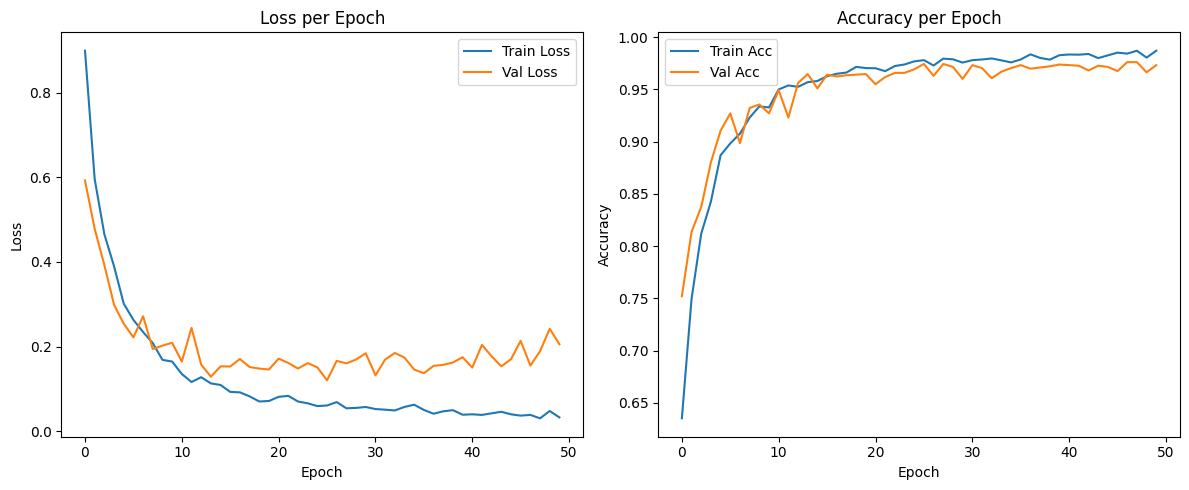


 Test Loss: 0.2059 | Test Accuracy: 0.9748


In [615]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = MRIDataset("image_data/train_images", "image_data/train.csv", transform=None)
valid_dataset = MRIDataset("image_data/valid_images", "image_data/valid.csv", transform=None)
test_dataset = MRIDataset("image_data/test_images", "image_data/test.csv", transform=None)


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

model = MRICNN(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)


train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=50, patience=3)
evaluate_on_test(model, test_loader, criterion, model_path="best_mri_model.pth")   # Evaluate on test


In [627]:
import cv2
import torch

def cv2_preprocess(image_path):
    """
    Reads a single‐channel image from disk and applies exactly
    the same resize→blur→normalize→scale pipeline you use in MRIDataset.
    Returns a torch.FloatTensor of shape [1,1,128,128].
    """
    # 1) load grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Could not read {image_path}")

    # 2) resize to 128×128
    img = cv2.resize(img, (128,128))

    # 3) median blur
    img = cv2.medianBlur(img, 3)

    # 4) normalize pixel values into [50,200]
    img = cv2.normalize(img, None, 50, 200, cv2.NORM_MINMAX)

    # 5) scale into [0,1]
    img = img.astype("float32") / 255.0

    # 6) to tensor [1,1,H,W]
    tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)
    return tensor  # dtype=torch.float32

def predict_single_image(image_path, model, device):
    model.eval()
    x = cv2_preprocess(image_path).to(device)
    with torch.no_grad():
        logits = model(x)
        idx    = logits.argmax(dim=1).item()
    return reversed_map[idx]

def predict_and_save(model_path, image_dir, output_txt="predictions.txt"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = MRICNN(num_classes=4).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))

    valid_exts = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}
    lines = []

    for fn in sorted(os.listdir(image_dir)):
        if os.path.splitext(fn)[1].lower() not in valid_exts:
            continue
        path = os.path.join(image_dir, fn)
        label = predict_single_image(path, model, device)
        lines.append(f"{fn}\t{label}")
        print(f"{fn} → {label}")

    with open(output_txt, "w") as f:
        f.write("\n".join(lines))
    print(f"\nWrote {len(lines)} predictions to {output_txt}")


In [628]:
predict_and_save(
  model_path="best_mri_model.pth",
  image_dir="image_data/test_images",
  output_txt="predictions.txt"
)


gl_0016_jpg.rf.99746694ea97fe0b73108832b462d48e.jpg → Glioma
gl_0018_jpg.rf.7a670766b8083a1b516a49e241a636bc.jpg → Glioma
gl_0028_jpg.rf.8098b9737048aac0dccb1b7c45046894.jpg → Glioma
gl_0032_jpg.rf.e1e485b4f909d84c8e24cd26e0ad3c08.jpg → Glioma
gl_0035_jpg.rf.7a7c96ab2e6245cf42a0c86b97f81b3e.jpg → Glioma
gl_0037_jpg.rf.6ac80086817a5d840d3b634956299e40.jpg → Glioma
gl_0040_jpg.rf.4e8e95e2b510b798b62954aa8d3e1847.jpg → Pituitary
gl_0042_jpg.rf.c825249fca17c0579976c6455ed0f64d.jpg → Glioma
gl_0075_jpg.rf.687ed8298bed6c85cb35c9c8f3ecbe2d.jpg → Glioma
gl_0081_jpg.rf.cd6ff4a250465f60361ab931fe2cd91f.jpg → Glioma
gl_0084_jpg.rf.a44aa8130cb9e42053acb60cbc60cb1e.jpg → Glioma
gl_0086_jpg.rf.59bef0b3cef3bf10bfa5f3c2ae2c656e.jpg → Glioma
gl_0093_jpg.rf.b5c9b66e96a5e1c0e472eaacac7ab14f.jpg → Glioma
gl_0094_jpg.rf.1c0f0e197cfcf7728469ebc07bc6db14.jpg → Glioma
gl_0099_jpg.rf.049ca340ff9cdd5a1ccd2b6cc48cc4fc.jpg → Meningioma
gl_0101_jpg.rf.11f5cfff6b549f258a54d8c0c8fb3921.jpg → Glioma
gl_0107_jpg.rf.99

In [629]:
gt = pd.read_csv("image_data/test.csv", header=None, names=["filename","true_label"])

# 2) Load your predictions
pred = pd.read_csv("predictions.txt", sep="\t", header=None, names=["filename","pred_label"])

# 3) Merge on filename
df = gt.merge(pred, on="filename", how="inner")

# 4) Compute accuracy
df["correct"] = (df["true_label"] == df["pred_label"])
accuracy = df["correct"].mean()

print(f"Matched {df['correct'].sum()} out of {len(df)} images.")
print(f"Accuracy: {accuracy*100:.2f}%")

Matched 851 out of 873 images.
Accuracy: 97.48%


# Confusion Matrix 

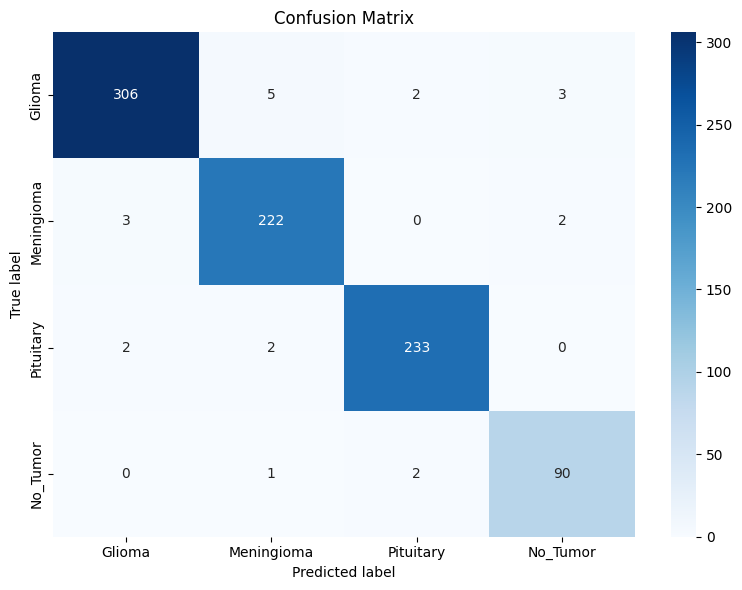

In [630]:
def compute_confusion_matrix(model, data_loader, device):
    """
    Returns a confusion matrix (2D numpy array) for model vs. labels in data_loader.
    """
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, class_names, figsize=(8,6)):
    """
    Plots the given confusion matrix (cm) with seaborn heatmap.
    """
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

# — example usage —

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Load your best model
model = MRICNN(num_classes=4).to(device)
model.load_state_dict(torch.load("best_mri_model.pth", map_location=device))

# 2) Compute
cm = compute_confusion_matrix(model, test_loader, device)

# 3) Plot
class_names = ["Glioma", "Meningioma", "Pituitary", "No_Tumor"]
plot_confusion_matrix(cm, class_names)


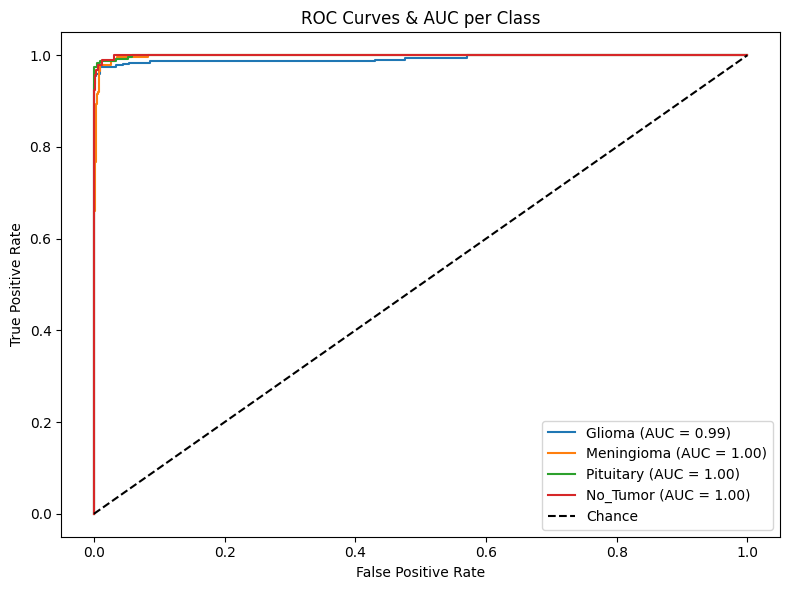

In [633]:
from sklearn.metrics import roc_curve, auc

device = torch.device("cpu")
model = MRICNN(num_classes=4)
state = torch.load("best_mri_model.pth", map_location=device)
model.load_state_dict(state)
model.to(device).eval()

# 2) Collect true labels and predicted probabilities
y_true = []
y_score = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        y_score.append(probs)
        y_true.append(labels.numpy())

y_true = np.concatenate(y_true)      # shape (N,)
y_score = np.concatenate(y_score)    # shape (N, num_classes)

# 3) Binarize labels for multi‑class ROC
n_classes = y_score.shape[1]
y_true_bin = np.zeros((len(y_true), n_classes))
for i in range(n_classes):
    y_true_bin[:, i] = (y_true == i).astype(int)

fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 5) Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i],
             label=f"{reversed_map[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves & AUC per Class")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


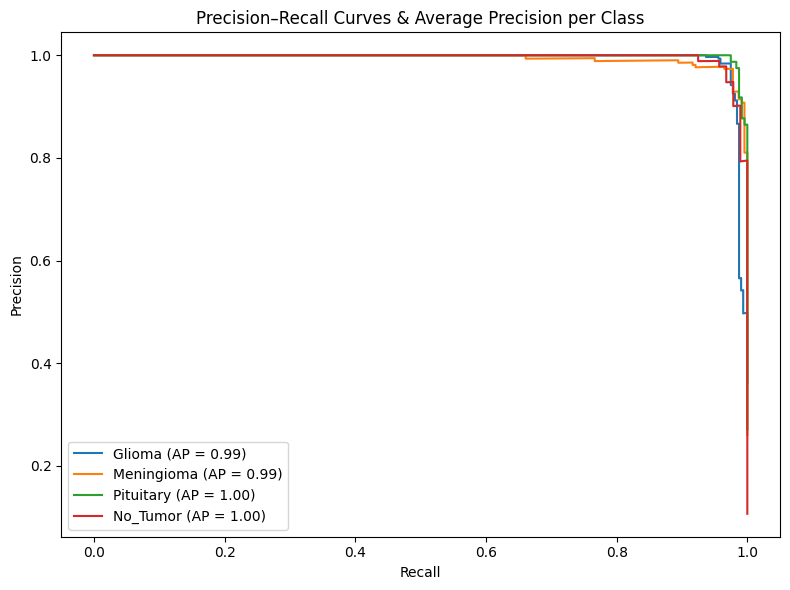

In [635]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# 2) Run the test_loader to collect true labels and predicted probabilities
y_true = []
y_score = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        y_score.append(probs)
        y_true.append(labels.numpy())

y_true  = np.concatenate(y_true)   # shape (N,)
y_score = np.concatenate(y_score)  # shape (N, num_classes)

# 3) Binarize labels for multi‐class PR
num_classes = y_score.shape[1]
y_true_bin = np.zeros((len(y_true), num_classes))
for i in range(num_classes):
    y_true_bin[:, i] = (y_true == i).astype(int)

# 4) Compute precision, recall, and AP for each class
precision = {}
recall    = {}
avg_prec  = {}
for i in range(num_classes):
    precision[i], recall[i], _  = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
    avg_prec[i] = average_precision_score(y_true_bin[:, i], y_score[:, i])

# 5) Plot Precision–Recall curves
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(recall[i], precision[i],
             label=f"{reversed_map[i]} (AP = {avg_prec[i]:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves & Average Precision per Class")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()
